In [1]:
import numpy as np 
import torch 
from torchvision import datasets,transforms
import matplotlib.pyplot as plt 
import seaborn as sns
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
transform=transforms.ToTensor()

In [3]:
train_data=datasets.MNIST('data',train=True,download=True,transform=transform)
test_data=datasets.MNIST('data',train=False,download=True,transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
valid_size=0.2
batch_size=20
num_workers=0

train_length = len(train_data)

# obtain training dataset indices that will be used for validation dataset
indices = list(range(train_length))

np.random.shuffle(indices)
split = int(np.floor(valid_size * train_length))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders for train, test and validation dataset
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

In [5]:
# This is for debugging
train_idx.__len__(),valid_idx.__len__()

(48000, 12000)

In [6]:
# Printing the length of our train, valid and test dataloaders
# NOTE : Here batch size is 20
len(train_loader),len(valid_loader),len(test_loader)

(2400, 600, 500)

In [7]:

# checking our data
dataiter=iter(train_loader)
images,labels=dataiter.next()
print(images, images.shape, len(images), images[0].shape)
print()
print(labels,labels.shape,len(labels))

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0.

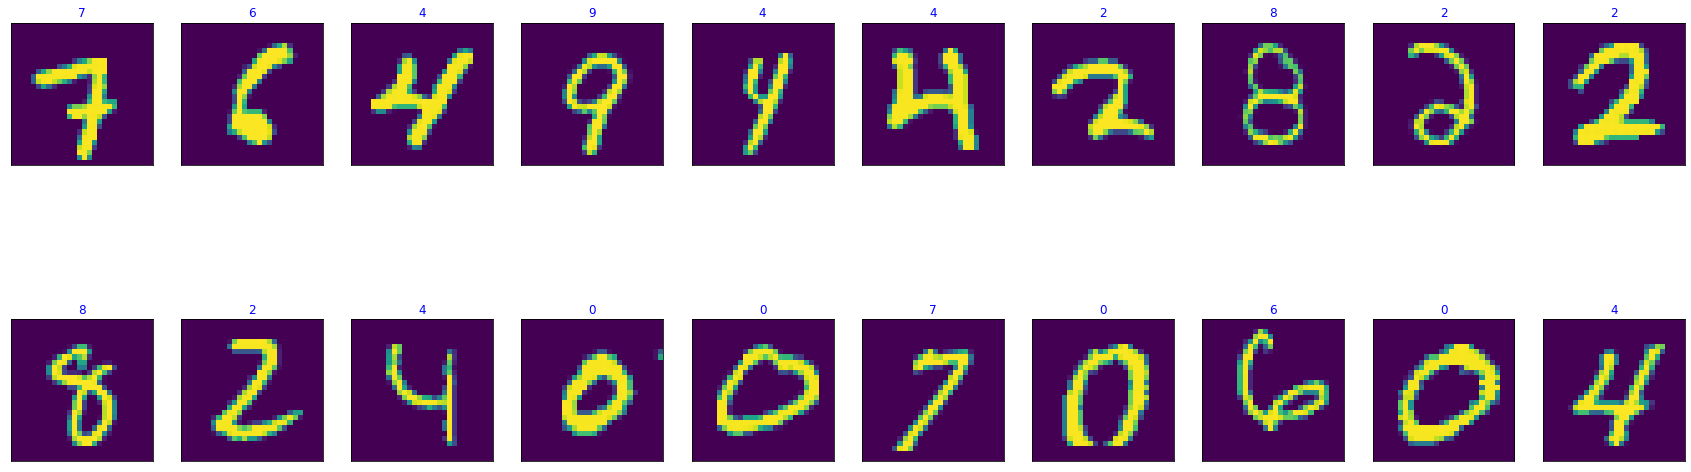

In [8]:
# Displaying images and labels of a batch
fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]))
    ax.set_title(labels[i].item(),color='blue')

In [9]:

# Model 1 : This model has dropout set to a certain value
# NOTE : When we want to use dropout we ensure we run train() method on our model --- during training , if not required we should use eval() method --- validation and testing
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)
        
        # Dropout probability - set for avoiding overfitting
        self.dropout=nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)        
        x=self.dropout(torch.sigmoid(self.fc1(x)))
        x=self.dropout(torch.sigmoid(self.fc2(x)))
        x=self.out(x)
        return x

class convNet(nn.Module):
  def __init__(self):
    super(convNet,self).__init__()
    self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
    self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
    self.pool=nn.MaxPool2d(kernel_size=2,stride=2)


    self.fc1=nn.Linear(7*7*32,128)
    self.fc2=nn.Linear(128,64)
    self.out=nn.Linear(64,10)
    self.dropout=nn.Dropout(0.2)

  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,7*7*32)
    x=self.dropout(F.relu(self.fc1(x)))
    x=self.dropout(F.relu(self.fc2(x)))
    x=self.out(x)
    return x
    

In [10]:
model_1=FNet()
model_2=convNet()

use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1.cuda()
  model_2.cuda()


print(model_1,'\n\n\n\n',model_2,'\n\n\n\n','On GPU : ',torch.cuda.is_available())

FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
) 



 On GPU :  True


In [11]:
# Loss Function
# If we did not compute softmax at output use nn.CrossentropyLoss() else use nn.NLLLoss()
criterion=nn.CrossEntropyLoss()


In [12]:
def trainNet(model,lr):
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)


    # Number of epochs to train for
    loss_keeper={'train':[],'valid':[]}
    epochs=20

    # minimum validation loss ----- set initial minimum to infinity
    valid_loss_min = np.Inf 

    for epoch in range(epochs):
        train_loss=0.0
        valid_loss=0.0

        """
        TRAINING PHASE
        """
        model.train() # TURN ON DROPOUT for training
        for images,labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            optimizer.zero_grad()
            output=model(images)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

        """
        VALIDATION PHASE
        """
        model.eval() # TURN OFF DROPOUT for validation
        for images,labels in valid_loader:
            if use_cuda and torch.cuda.is_available():
                images,labels=images.cuda(),labels.cuda()
            output=model(images)
            loss=criterion(output,labels)
            valid_loss+=loss.item()*images.size(0)

        # Calculating loss over entire batch size for every epoch
        train_loss = train_loss/len(train_loader)
        valid_loss = valid_loss/len(valid_loader)


        # saving loss values
        loss_keeper['train'].append(train_loss)
        loss_keeper['valid'].append(valid_loss)

        print(f"\nEpoch : {epoch+1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
        if valid_loss<=valid_loss_min:
            print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")
        z=type(model).__name__
        torch.save(model.state_dict(), z+'_model.pth')
        valid_loss_min=valid_loss
    return(loss_keeper)

In [13]:
m1_loss=trainNet(model_1,0.001)


Epoch : 1	Training Loss : 0.3942721354099922	Validation Loss : 3.851014688083281
Validation loss decreased from : inf ----> 3.851014688083281 ----> Saving Model.......

Epoch : 2	Training Loss : 0.15818775087750206	Validation Loss : 2.6973006478510797
Validation loss decreased from : 3.851014688083281 ----> 2.6973006478510797 ----> Saving Model.......

Epoch : 3	Training Loss : 0.10704881710606666	Validation Loss : 2.200614791553623
Validation loss decreased from : 2.6973006478510797 ----> 2.200614791553623 ----> Saving Model.......

Epoch : 4	Training Loss : 0.08155552950959342	Validation Loss : 1.9448087599923989
Validation loss decreased from : 2.200614791553623 ----> 1.9448087599923989 ----> Saving Model.......

Epoch : 5	Training Loss : 0.06278491280798335	Validation Loss : 1.7124739122994166
Validation loss decreased from : 1.9448087599923989 ----> 1.7124739122994166 ----> Saving Model.......

Epoch : 6	Training Loss : 0.050623083819124684	Validation Loss : 1.845539183257885

Ep

In [14]:
m1_loss

{'train': [0.3942721354099922,
  0.15818775087750206,
  0.10704881710606666,
  0.08155552950959342,
  0.06278491280798335,
  0.050623083819124684,
  0.04131530463704621,
  0.03235638693486635,
  0.028908442060066288,
  0.025080019377067705,
  0.021854285011485976,
  0.019074331936744595,
  0.0177891193006667,
  0.014488286191163031,
  0.015334255266302345,
  0.011709081790295551,
  0.011876725266765338,
  0.011777527882674856,
  0.011194145371538108,
  0.008668503413878786],
 'valid': [3.851014688083281,
  2.6973006478510797,
  2.200614791553623,
  1.9448087599923989,
  1.7124739122994166,
  1.845539183257885,
  1.7445352342207723,
  1.5650116661431335,
  1.7956537370144967,
  1.7989062425839317,
  1.8070113121448987,
  2.0096796326188495,
  1.9050446625749147,
  1.9594716520297577,
  2.000778223154297,
  1.9877293855716933,
  2.085446601572561,
  1.9882997543174743,
  2.203404566768963,
  2.125516231520108]}

In [15]:
m2_loss=trainNet(model_2,0.001)


Epoch : 1	Training Loss : 0.24557665396641823	Validation Loss : 1.468475347487644
Validation loss decreased from : inf ----> 1.468475347487644 ----> Saving Model.......

Epoch : 2	Training Loss : 0.08156349745859189	Validation Loss : 1.3160098719701636
Validation loss decreased from : 1.468475347487644 ----> 1.3160098719701636 ----> Saving Model.......

Epoch : 3	Training Loss : 0.058205044158442736	Validation Loss : 0.9815504983026282
Validation loss decreased from : 1.3160098719701636 ----> 0.9815504983026282 ----> Saving Model.......

Epoch : 4	Training Loss : 0.04696589246895845	Validation Loss : 1.16142220276973

Epoch : 5	Training Loss : 0.039171607902864405	Validation Loss : 0.9993973114193371
Validation loss decreased from : 1.16142220276973 ----> 0.9993973114193371 ----> Saving Model.......

Epoch : 6	Training Loss : 0.031557237623693196	Validation Loss : 1.036189173197378

Epoch : 7	Training Loss : 0.02626154114730468	Validation Loss : 1.0647650636093962

Epoch : 8	Training 

In [16]:
m2_loss

{'train': [0.24557665396641823,
  0.08156349745859189,
  0.058205044158442736,
  0.04696589246895845,
  0.039171607902864405,
  0.031557237623693196,
  0.02626154114730468,
  0.022763645219642897,
  0.022291436652796516,
  0.020694627869929386,
  0.018313878365213844,
  0.01754687967287693,
  0.014795085023770511,
  0.01574798378470881,
  0.01287691728447062,
  0.013430670460637444,
  0.011734406551822655,
  0.01241992243932665,
  0.013123226007220655,
  0.011771963096619112],
 'valid': [1.468475347487644,
  1.3160098719701636,
  0.9815504983026282,
  1.16142220276973,
  0.9993973114193371,
  1.036189173197378,
  1.0647650636093962,
  1.105473443804493,
  1.0295909132774497,
  1.1752712524281945,
  0.984053314349549,
  1.0097921130457324,
  1.211064347450515,
  1.1186320674932346,
  1.0607951479123605,
  1.242633450789075,
  1.2559604437485246,
  1.1455972935944716,
  1.0808640793918227,
  1.232102497676188]}

In [17]:
# Loading the model from the lowest validation loss 
model_1.load_state_dict(torch.load('FNet_model.pth'))
model_2.load_state_dict(torch.load('convNet_model.pth'))


<All keys matched successfully>

In [18]:
print(model_1.state_dict,'\n\n\n\n',model_2.state_dict)

<bound method Module.state_dict of FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)> 



 <bound method Module.state_dict of convNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)>


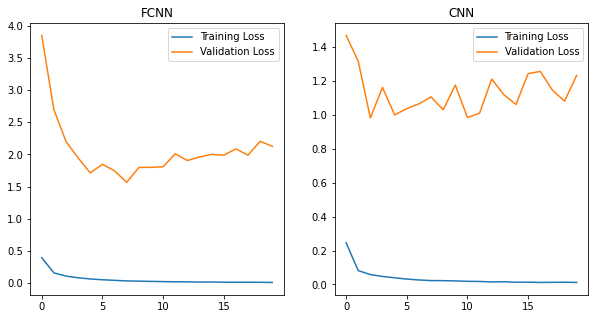

In [19]:
title=['FCNN','CNN']
model_losses=[m1_loss,m2_loss]
fig=plt.figure(1,figsize=(10,5))
idx=1
for i in model_losses:
  ax=fig.add_subplot(1,2,idx)
  ax.plot(i['train'],label="Training Loss")
  ax.plot(i['valid'],label="Validation Loss")
  ax.set_title(title[idx-1])
  idx+=1
  plt.legend();

In [24]:
def test(model):
    correct=0
    test_loss=0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    model.eval() # test the model with dropout layers off
    for images,labels in test_loader:
        if use_cuda and torch.cuda.is_available():
            images,labels=images.cuda(),labels.cuda()
        output=model(images)
        loss=criterion(output,labels)
        test_loss+=loss.item()
        _,pred=torch.max(output,1)
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

        for i in range(batch_size):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1


    test_loss=test_loss/len(train_loader)
    print(f'For {type(model).__name__} :')
    print(f"Test Loss: {test_loss}")
    print(f"Correctly predicted per class : {class_correct}, Total correctly perdicted : {sum(class_correct)}")
    print(f"Total Predictions per class : {class_total}, Total predictions to be made : {sum(class_total)}\n")
    for i in range(10):
      if class_total[i] > 0:
          print(f"Test Accuracy of class {i} : {int(100 * class_correct[i] / class_total[i])}% where {int(np.sum(class_correct[i]))} of {int(np.sum(class_total[i]))} were predicted correctly")
      else:
          print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print(f"\nOverall Test Accuracy : {int(100. * np.sum(class_correct) / np.sum(class_total))}% where {int(np.sum(class_correct))} of {int(np.sum(class_total))} were predicted correctly")
    # obtain one batch of test images
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # get sample outputs
    if use_cuda and torch.cuda.is_available():
      images,labels=images.cuda(),labels.cuda()
    output = model(images)
    # convert output probabilities to predicted class
    _, preds = torch.max(output, 1)
    # prep images for display
    images = images.cpu().numpy()

    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]))
        ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                    color=("blue" if preds[idx]==labels[idx] else "red"))

For FNet :
Test Loss: 0.019070595134698887
Correctly predicted per class : [969.0, 1125.0, 1021.0, 1002.0, 961.0, 857.0, 937.0, 1013.0, 954.0, 979.0], Total correctly perdicted : 9818.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 98% where 969 of 980 were predicted correctly
Test Accuracy of class 1 : 99% where 1125 of 1135 were predicted correctly
Test Accuracy of class 2 : 98% where 1021 of 1032 were predicted correctly
Test Accuracy of class 3 : 99% where 1002 of 1010 were predicted correctly
Test Accuracy of class 4 : 97% where 961 of 982 were predicted correctly
Test Accuracy of class 5 : 96% where 857 of 892 were predicted correctly
Test Accuracy of class 6 : 97% where 937 of 958 were predicted correctly
Test Accuracy of class 7 : 98% where 1013 of 1028 were predicted correctly
Test Accuracy of class 8 : 97% where 954 of 974 were predicted correctly
Te

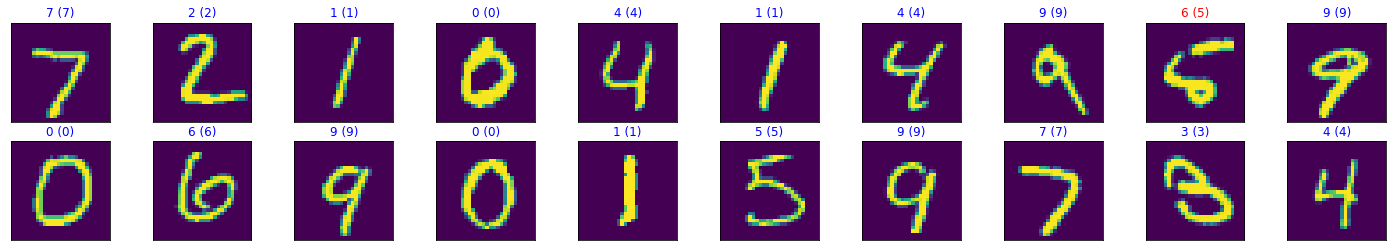

In [25]:
test(model_1)

For convNet :
Test Loss: 0.00855777870431757
Correctly predicted per class : [978.0, 1127.0, 1026.0, 1004.0, 977.0, 886.0, 945.0, 1019.0, 964.0, 989.0], Total correctly perdicted : 9915.0
Total Predictions per class : [980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0], Total predictions to be made : 10000.0

Test Accuracy of class 0 : 99% where 978 of 980 were predicted correctly
Test Accuracy of class 1 : 99% where 1127 of 1135 were predicted correctly
Test Accuracy of class 2 : 99% where 1026 of 1032 were predicted correctly
Test Accuracy of class 3 : 99% where 1004 of 1010 were predicted correctly
Test Accuracy of class 4 : 99% where 977 of 982 were predicted correctly
Test Accuracy of class 5 : 99% where 886 of 892 were predicted correctly
Test Accuracy of class 6 : 98% where 945 of 958 were predicted correctly
Test Accuracy of class 7 : 99% where 1019 of 1028 were predicted correctly
Test Accuracy of class 8 : 98% where 964 of 974 were predicted correctly


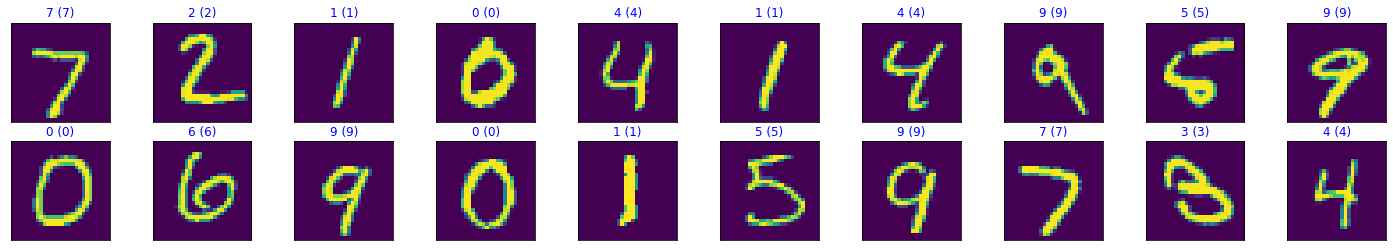

In [26]:
test(model_2)